In [70]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

## $\mathcal{F}$-statistics

In [71]:
import copy 

class Fstatistics(Likelihood):
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        super().__init__(response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu)
        self.SUM = self.xp.sum 
        self.CONJ = self.xp.conjugate
        self.RE = self.xp.real
        self.NX = self.xp.newaxis 
        self.MATMUL = self.xp.matmul
        self.TRANS = self.xp.transpose

    def self_inner_product_vectorized(self, template_channels):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def inner_product_vectorized(self, template_channels1, template_channels2):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)

    def calculate_Fstat_vectorized(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized(data_expand, X1), 
            self.inner_product_vectorized(data_expand, X2), 
            self.inner_product_vectorized(data_expand, X3), 
            self.inner_product_vectorized(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized(X1, X3)
        M14 = self.inner_product_vectorized(X1, X4)
        M23 = self.inner_product_vectorized(X2, X3)
        M24 = self.inner_product_vectorized(X2, X4)
        M34 = self.inner_product_vectorized(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            return res.get() # (Nevent)
        else: 
            return res 
        
    @staticmethod
    def a_to_extrinsic(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (Nevent, 4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a, axis=1) ** 2 # (Nevent)
        Q = a[:, 1] * a[:, 2] - a[:, 0] * a[:, 3] # (Nevent)
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # (Nevent)
        Aplus = np.sqrt((P + Delta) / 2.) # (Nevent)
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # (Nevent)
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # (Nevent)
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # (Nevent)
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # (Nevent)
        extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 
        
        return extrinsic_parameters
    
    @staticmethod
    def IntParamDict2ParamArr(param_dict):
        return np.array([
            np.log10(param_dict['chirp_mass']),
            param_dict['mass_ratio'],
            param_dict['spin_1z'],
            param_dict['spin_2z'],
            param_dict['coalescence_time'],
            param_dict['longitude'],
            np.sin(param_dict['latitude']),
        ]) # (Nparams, Nevent)

    @staticmethod
    def IntParamArr2ParamDict(params):
        p = dict()
        p['chirp_mass'] = np.power(10., params[0])
        p['mass_ratio'] = params[1]
        p['spin_1z'] = params[2]
        p['spin_2z'] = params[3]
        p['coalescence_time'] = params[4]
        p['longitude'] = params[5]
        p['latitude'] = np.arcsin(params[6])
        return p 

## Data settings 

In [72]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [73]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [74]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [75]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 1-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 1696636.7373511351,
 'mass_ratio': 0.16576299645294834,
 'spin_1z': 0.946273159259182,
 'spin_2z': 0.8808045606435004,
 'coalescence_time': 13.719083142136824,
 'coalescence_phase': 4.476620037801342,
 'luminosity_distance': 68952.74570921765,
 'inclination': 1.010737179536263,
 'longitude': 4.042171593250117,
 'latitude': -0.4010715777943519,
 'psi': 1.5070292960539273}

In [76]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [77]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

In [78]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

1000.517583588994

## Data combination 

In [79]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

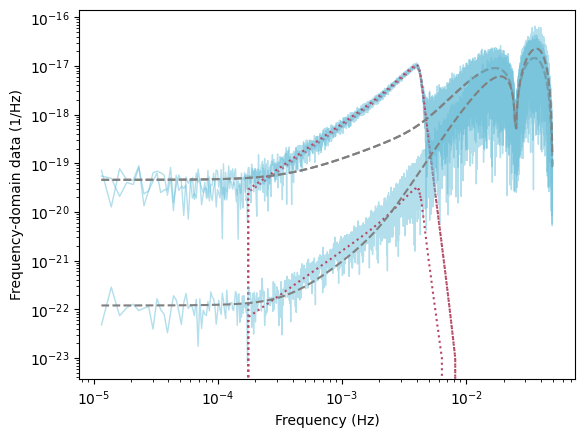

In [80]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [81]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


In [82]:
int_params = copy.deepcopy(mbhb_parameters)
for key in ["luminosity_distance", "inclination", "coalescence_phase", "psi"]:
    int_params.pop(key)

N_fstat_test = 2
for k, v in int_params.items():
    int_params[k] = np.ones(N_fstat_test) * v 

int_params

{'chirp_mass': array([1696636.73735114, 1696636.73735114]),
 'mass_ratio': array([0.165763, 0.165763]),
 'spin_1z': array([0.94627316, 0.94627316]),
 'spin_2z': array([0.88080456, 0.88080456]),
 'coalescence_time': array([13.71908314, 13.71908314]),
 'longitude': array([4.04217159, 4.04217159]),
 'latitude': array([-0.40107158, -0.40107158])}

In [83]:
Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=False, 
    return_recovered_wave=False, 
)

array([501211.64563956, 501211.64563956])

### compare $\mathcal{F}$-stat and likelihood around truths

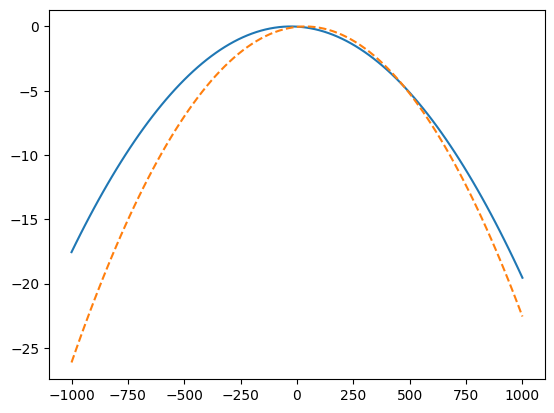

In [84]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in ["luminosity_distance", "inclination", "coalescence_phase", "psi"]:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F))
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--")

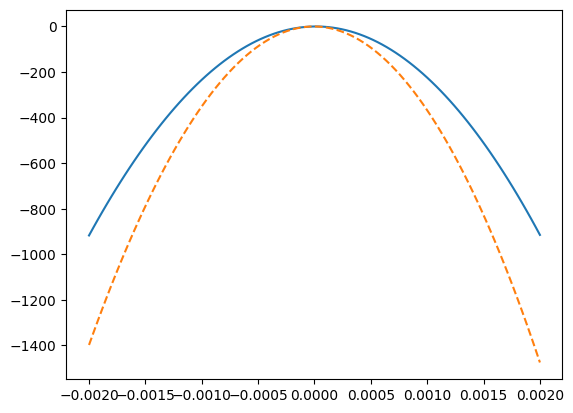

In [85]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in ["luminosity_distance", "inclination", "coalescence_phase", "psi"]:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.002, 0.002, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F))
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--")

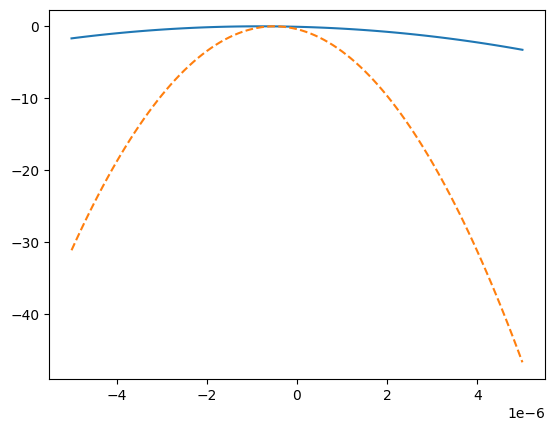

In [86]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in ["luminosity_distance", "inclination", "coalescence_phase", "psi"]:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-5e-6, 5e-6, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F))
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--")

### test waveform and parameter recovery

In [87]:
int_params = copy.deepcopy(mbhb_parameters)
for key in ["luminosity_distance", "inclination", "coalescence_phase", "psi"]:
    int_params.pop(key)

N_fstat_test = 2
for k, v in int_params.items():
    int_params[k] = np.ones(N_fstat_test) * v 

int_params

{'chirp_mass': array([1696636.73735114, 1696636.73735114]),
 'mass_ratio': array([0.165763, 0.165763]),
 'spin_1z': array([0.94627316, 0.94627316]),
 'spin_2z': array([0.88080456, 0.88080456]),
 'coalescence_time': array([13.71908314, 13.71908314]),
 'longitude': array([4.04217159, 4.04217159]),
 'latitude': array([-0.40107158, -0.40107158])}

In [88]:
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave.shape

(3, 2, 21077)

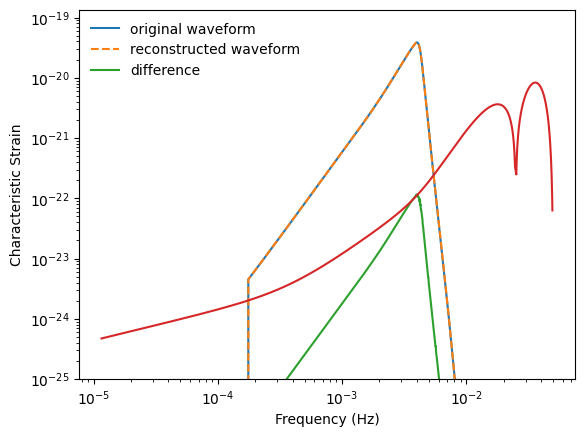

In [89]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [90]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
rec_a

array([[ 4.32671390e-06,  1.67152152e-06,  1.20846677e-06,
        -3.67852948e-06],
       [ 4.32671390e-06,  1.67152152e-06,  1.20846677e-06,
        -3.67852948e-06]])

In [91]:
rec_ext_params = Fstat.a_to_extrinsic(rec_a)
for k, v in rec_ext_params.items():
    print(k, v[0], mbhb_parameters[k])

luminosity_distance 68914.69656488615 68952.74570921765
inclination 1.010546862579329 1.010737179536263
coalescence_phase -0.4828311553267106 4.476620037801342
psi -0.06874281474884603 1.5070292960539273


### optimization from prior 

In [ ]:
intrinsic_parameter_names = [
    'chirp_mass',
    'mass_ratio',
    'spin_1z',
    'spin_2z',
    'coalescence_time',
    'longitude',
    'latitude'
    ]

intrinsic_parameter_ranges = {
    'chirp_mass': [5e5, 5e6],
    'mass_ratio': [0.1, 1.],
    'spin_1z': [-0.9, 0.9],
    'spin_2z': [-0.9, 0.9],
    'coalescence_time': [mbhb_parameters["coalescence_time"]-0.01, mbhb_parameters["coalescence_time"]+0.01],
    'longitude': [0, TWOPI],
    'latitude': 
}

['chirp_mass',
 'mass_ratio',
 'spin_1z',
 'spin_2z',
 'coalescence_time',
 'longitude',
 'latitude']

In [ ]:
    # @staticmethod
    # def IntParamDict2ParamArr(param_dict):
    #     return np.array([
    #         np.log10(param_dict['chirp_mass']),
    #         param_dict['mass_ratio'],
    #         param_dict['spin_1z'],
    #         param_dict['spin_2z'],
    #         param_dict['coalescence_time'],
    #         param_dict['longitude'],
    #         np.sin(param_dict['latitude']),
    #     ]) # (Nparams, Nevent)

## Fisher analysis 
calculate the theoretical bounds 

In [27]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 9.005355842766562
shift = 5.0 relative diff = 7.711945423719868e-07
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.005972166113884078
shift = 0.005 relative diff = 0.0018756946860089857
error = 0.005962344907102491
shift = 0.0025 relative diff = 0.002261862335292511
error = 0.005957810200752449
shift = 0.00125 r

In [28]:
FIM.param_errors

{'chirp_mass': 409.9056212796168,
 'mass_ratio': 0.0006862299071047627,
 'spin_1z': 0.003902343811273223,
 'spin_2z': 0.018524843030291546,
 'coalescence_time': 3.655187845240722e-05,
 'coalescence_phase': 0.5872605939634874,
 'luminosity_distance': 15079.5011647829,
 'inclination': 0.6563708392834688,
 'longitude': 0.00900716414957556,
 'latitude': 0.04550228278720843,
 'psi': 0.6140529413437109}

1822.3882801148175

## Likelihood 

In [30]:
Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


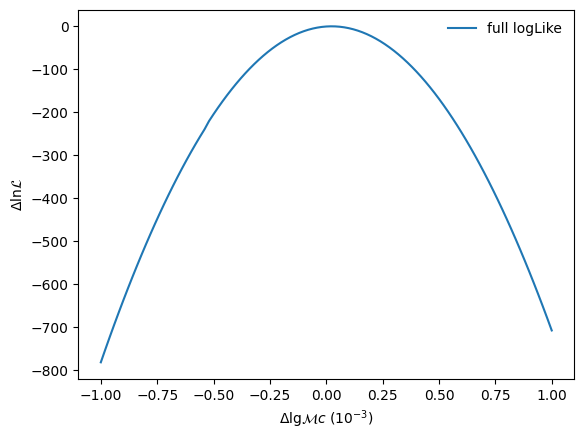

In [31]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)

N_test=101
test_idx = 0 # lgMc 
test_params = np.linspace(-1e-3, 1e-3, N_test) + fiducial_param_arr[test_idx]

full_lls = [] # store the full loglikelihood 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
full_lls = np.array(full_lls)

plt.plot((test_params - fiducial_param_arr[test_idx])*1e3, full_lls - np.max(full_lls), label="full logLike")
plt.xlabel(r'$\Delta {\rm lg} \mathcal{M}c \ (10^{-3})$')
plt.ylabel(r'$\Delta {\rm ln} \mathcal{L}$')
plt.legend(frameon=False)

## Bilby wrapper 

In [15]:
import bilby 

In [16]:
priors = bilby.core.prior.PriorDict()
priors["chirp_mass"] = bilby.prior.Uniform(minimum=mbhb_parameters["chirp_mass"]-10.*FIM.param_errors["chirp_mass"], maximum=mbhb_parameters["chirp_mass"]+10.*FIM.param_errors["chirp_mass"], name='chirp_mass', latex_label='$\mathcal{M}_c$')
priors["mass_ratio"] = bilby.prior.Uniform(minimum=max(0.1, mbhb_parameters["mass_ratio"]-10.*FIM.param_errors["mass_ratio"]), maximum=min(1., mbhb_parameters["mass_ratio"]+10.*FIM.param_errors["mass_ratio"]), name="mass_ratio", latex_label='$q$')
priors["spin_1z"] = bilby.prior.Uniform(minimum=max(-0.99, mbhb_parameters["spin_1z"]-10.*FIM.param_errors["spin_1z"]), maximum=min(0.99, mbhb_parameters["spin_1z"]+10.*FIM.param_errors["spin_1z"]), name="spin_1z", latex_label='$\chi_{z1}$')
priors["spin_2z"] = bilby.prior.Uniform(minimum=max(-0.99, mbhb_parameters["spin_2z"]-10.*FIM.param_errors["spin_2z"]), maximum=min(0.99, mbhb_parameters["spin_2z"]+10.*FIM.param_errors["spin_2z"]), name="spin_2z", latex_label='$\chi_{z2}$')
priors["coalescence_time"] = bilby.prior.Uniform(minimum=mbhb_parameters["coalescence_time"]-10.*FIM.param_errors["coalescence_time"], maximum=mbhb_parameters["coalescence_time"]+10.*FIM.param_errors["coalescence_time"], name="coalescence_time", latex_label='$t_c$') 
priors["coalescence_phase"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="coalescence_phase", latex_label='$\\varphi_c$', boundary="periodic")
priors["luminosity_distance"] = bilby.prior.Uniform(minimum=mbhb_parameters["luminosity_distance"]-10.*FIM.param_errors["luminosity_distance"], maximum=mbhb_parameters["luminosity_distance"]+10.*FIM.param_errors["luminosity_distance"], name="luminosity_distance", latex_label='$d_L$')
priors["inclination"] = bilby.prior.Sine(minimum=0., maximum=PI, name="inclination", latex_label='$\iota$')
priors["longitude"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="longitude", latex_label='$\lambda$', boundary="periodic")
priors["latitude"] = bilby.prior.Cosine(minimum=-PI/2., maximum=PI/2., name="latitude", latex_label='$\\beta$')
priors["psi"] = bilby.prior.Uniform(minimum=0., maximum=PI, name="psi", latex_label='$\psi$', boundary="periodic")

In [17]:
priors

{'chirp_mass': Uniform(minimum=1531794.5903308636, maximum=1549873.5585351258, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5730828705896598, maximum=0.8440284230849848, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'spin_1z': Uniform(minimum=-0.99, maximum=0.7271270964950249, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None),
 'spin_2z': Uniform(minimum=-0.6244473157095929, maximum=0.99, name='spin_2z', latex_label='$\\chi_{z2}$', unit=None, boundary=None),
 'coalescence_time': Uniform(minimum=14.152558878348442, maximum=14.154440386706204, name='coalescence_time', latex_label='$t_c$', unit=None, boundary=None),
 'coalescence_phase': Uniform(minimum=0.0, maximum=6.283185307179586, name='coalescence_phase', latex_label='$\\varphi_c$', unit=None, boundary='periodic'),
 'luminosity_distance': Uniform(minimum=16868.74060253163, maximum=141047.6636953444, name='luminosity_distance', la

In [18]:
class bilby_likelihood_wrapper(bilby.Likelihood):
    def __init__(self, triangle_likelihood, likelihood_type="full"):
        """ wrap a triangle likelihood to get a bilby likelihood, type can be "full" or "heterodyned" """
        super().__init__(
            parameters={
                'chirp_mass': None,
                'mass_ratio': None,
                'spin_1z': None,
                'spin_2z': None,
                'coalescence_time': None,
                'coalescence_phase': None,
                'luminosity_distance': None,
                'inclination': None,
                'longitude': None,
                'latitude': None,
                'psi': None
            }
        )
        if likelihood_type == "full":
            self.LLfunc = triangle_likelihood.full_log_like
        elif likelihood_type == "heterodyned":
            self.LLfunc = triangle_likelihood.het_log_like
        else:
            raise ValueError("wrong likelihood type. it should only be full or heterodyned.")

    def log_likelihood(self):
        return self.LLfunc(ParamDict2ParamArr(self.parameters))

In [19]:
BLike_full = bilby_likelihood_wrapper(triangle_likelihood=Like, likelihood_type="full")

In [20]:
sampler_name = "nessai"
# sampler_name = "dynesty"

In [ ]:
# import multiprocessing
# print("number of cpus =", multiprocessing.cpu_count())

result = bilby.run_sampler(
    likelihood=BLike_full, 
    priors=priors,
    sampler=sampler_name, 
    nlive=1000,
    walks=20,
    nact=50,
    maxmcmc=2000,
    dlogz=0.3,
    # npool=multiprocessing.cpu_count(),
    npool=None, 
    injection_parameters=mbhb_parameters, 
    outdir="../../Results/bilby_outdir",
    label="test_full_likelihood_5day",
    plot=True,
    resume=False, 
    # resume=True, 
)

17:00 bilby INFO    : Running for label 'test_full_likelihood_5day', output will be saved to '../../Results/bilby_outdir'
/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/bilby/core/utils/log.py:73: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
17:00 bilby INFO    : Analysis priors:
17:00 bilby INFO    : chirp_mass=Uniform(minimum=1531794.5903308636, maximum=1549873.5585351258, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None)
17:00 bilby INFO    : mass_ratio=Uniform(minimum=0.5730828705896598, maximum=0.8440284230849848, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
17:00 bilby INFO    : spin_1z=Uniform(minimum=-0.99, maximum=0.7271270964950249, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None)
17:00 bilby INFO    : s

07-14 17:00 nessai INFO    : Running Nessai version 0.14.0.post0
07-14 17:00 nessai INFO    : pool and n_pool are none, no multiprocessing pool
07-14 17:00 nessai INFO    : Initialising nested sampler


/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/nessai/utils/logging.py:133: FutureWarning: setup_logger is deprecated, use configure_logger instead
  warnings.warn(


07-14 17:00 nessai WARNING : Multiprocessing pool has already been configured.
07-14 17:00 nessai WARNING : Removing unused keyword arguments ({'max_n_clusters', 'n_steps', 'marginalise_augment', 'step_type', 'generate_augment', 'n_marg', 'plot_chain', 'step_kwargs', 'augment_dims', 'ensemble_fraction', 'enforce_likelihood_threshold', 'plot_history', 'n_accept'}) from kwargs for FlowProposal. These are valid keyword arguments but correspond to other proposal classes.
07-14 17:00 nessai INFO    : Passing kwargs to FlowProposal: {'training_config': None, 'poolsize': 1000, 'check_acceptance': False, 'max_poolsize_scale': 10, 'update_poolsize': True, 'accumulate_weights': False, 'save_training_data': False, 'reparameterisations': None, 'fallback_reparameterisation': 'zscore', 'use_default_reparameterisations': None, 'reverse_reparameterisations': False, 'map_to_unit_hypercube': False, 'latent_prior': 'truncated_gaussian', 'constant_volume_mode': True, 'volume_fraction': 0.95, 'fuzz': 1.0, 

In [ ]:
# Make a corner plot.
result.plot_corner(save=True)